In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [2]:
print(tf.__version__)

2.3.0


In [3]:
import cv2
import os
import random
import numpy as np

In [ ]:
pwd

In [12]:
POS_PATH = os.path.join('data', 'pos')
NEG_PATH = os.path.join('data', 'neg')
ANC_PATH = os.path.join('data', 'anc')

In [ ]:
POS_PATH

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
exam = anchor.as_numpy_iterator()

In [9]:
exam.next()

b'data\\anc\\1ddde45c-4261-11ec-8a67-acd1b8d9acb4.jpg'

In [4]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [11]:
img = preprocess('data\\anc\\1ddde45c-4261-11ec-8a67-acd1b8d9acb4.jpg')

In [12]:
img.numpy().max() 

0.7730392

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
samples = data.as_numpy_iterator()
exampple = samples.next()

In [15]:
exampple

(b'data\\anc\\1b06af3a-4261-11ec-9e27-acd1b8d9acb4.jpg',
 b'data\\pos\\5a8278cb-4261-11ec-93e3-acd1b8d9acb4.jpg',
 1.0)

In [5]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [17]:
!pip install matplotlib

In [24]:
from matplotlib import pyplot as plt

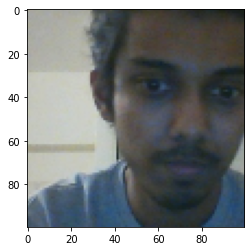

In [20]:
res = preprocess_twin(*exampple)
plt.imshow(res[1])

In [15]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [16]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [17]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [24]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [25]:
embedding = make_embedding()

In [26]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [6]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [28]:
l1 = L1Dist()

In [30]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [31]:
siamese_model = make_siamese_model()

In [32]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [5]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [6]:
opt = tf.keras.optimizers.Adam(1e-4)

In [35]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [36]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [37]:
EPOCHS = 49

In [40]:
train(train_data, EPOCHS)


 Epoch 1/49
27/27 [==============================] - 660s 24s/step

 Epoch 2/49
27/27 [==============================] - 623s 23s/step

 Epoch 3/49
27/27 [==============================] - 617s 23s/step

 Epoch 4/49
27/27 [==============================] - 611s 23s/step

 Epoch 5/49
27/27 [==============================] - 660s 24s/step

 Epoch 6/49
27/27 [==============================] - 608s 23s/step

 Epoch 7/49
27/27 [==============================] - 606s 22s/step

 Epoch 8/49
27/27 [==============================] - 614s 23s/step

 Epoch 9/49
27/27 [==============================] - 619s 23s/step

 Epoch 10/49
27/27 [==============================] - 609s 23s/step

 Epoch 11/49
27/27 [==============================] - 609s 23s/step

 Epoch 12/49
27/27 [==============================] - 611s 23s/step

 Epoch 13/49
27/27 [==============================] - 611s 23s/step

 Epoch 14/49
27/27 [==============================] - 784s 29s/step

 Epoch 15/49
27/27 [======================

In [41]:
siamese_model.save('siamesemodel.h5')

In [7]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [8]:
os.listdir(os.path.join('application_data', 'verification_images'))

['1e0922b7-4261-11ec-affb-acd1b8d9acb4.jpg',
 '1e3487fb-4261-11ec-b7bf-acd1b8d9acb4.jpg',
 '1e62522f-4261-11ec-893b-acd1b8d9acb4.jpg',
 '1e951fa4-4261-11ec-a7fe-acd1b8d9acb4.jpg',
 '4e30173d-4261-11ec-b5ca-acd1b8d9acb4.jpg',
 '4e80348c-4261-11ec-901e-acd1b8d9acb4.jpg',
 '4ea11c5b-4261-11ec-98d3-acd1b8d9acb4.jpg',
 '4ea87b66-4261-11ec-ab70-acd1b8d9acb4.jpg',
 '4ebfb885-4261-11ec-b5bb-acd1b8d9acb4.jpg',
 '4ec74828-4261-11ec-9f6d-acd1b8d9acb4.jpg',
 '4ecef5fc-4261-11ec-b68d-acd1b8d9acb4.jpg',
 '4ef6d4d2-4261-11ec-a8b3-acd1b8d9acb4.jpg',
 '4efe5ff4-4261-11ec-b82a-acd1b8d9acb4.jpg',
 '4f0879ae-4261-11ec-be56-acd1b8d9acb4.jpg',
 '4f24a59d-4261-11ec-9d8d-acd1b8d9acb4.jpg',
 '4f2bfc71-4261-11ec-a0cd-acd1b8d9acb4.jpg',
 '4f3358a7-4261-11ec-acae-acd1b8d9acb4.jpg',
 '4f3cebbd-4261-11ec-8132-acd1b8d9acb4.jpg',
 '4f4e987b-4261-11ec-acfa-acd1b8d9acb4.jpg',
 '4f55fbe5-4261-11ec-bcc5-acd1b8d9acb4.jpg',
 '4f5f9f35-4261-11ec-8a29-acd1b8d9acb4.jpg',
 '4f66ef5a-4261-11ec-8b5d-acd1b8d9acb4.jpg',
 '4f78f893

In [9]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [37]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verificatiqon trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True


In [32]:
np.sum(np.squeeze(results) > 0.9)

32

In [11]:
from tensorflow.keras.metrics import Precision, Recall

In [18]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [20]:
# Make predictions
y_hat = model.predict([test_input, test_val])

In [21]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

In [22]:
y_true

array([0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

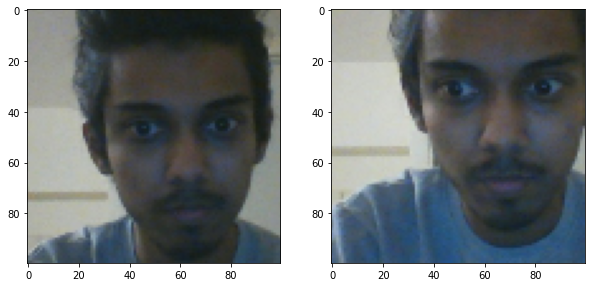

In [33]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()